## **Experiment 1: Basic CNN, VGG166, ResNet50 & DenseNet121**

In [ ]:
import tensorflow as tf
print("TensorFlow Version:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices("GPU"))

TensorFlow Version: 2.19.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
BASE_DIR  = "/content/drive/MyDrive/archive/ODIR-5K/ODIR-5K"

# cek isi folder ini dulu
print(os.listdir(BASE_DIR))

TRAIN_DIR = os.path.join(BASE_DIR, "Training Images")
TEST_DIR  = os.path.join(BASE_DIR, "Testing Images")

META_PATH = os.path.join(BASE_DIR, "data.xlsx")

print("BASE_DIR :", BASE_DIR)
print("TRAIN_DIR:", TRAIN_DIR, os.path.exists(TRAIN_DIR))
print("TEST_DIR :", TEST_DIR,  os.path.exists(TEST_DIR))
print("META_PATH:", META_PATH, os.path.exists(META_PATH))
df = pd.read_excel(META_PATH)
df.head()
df.columns

# nama kolom sesuai yang di file df
IMG_LEFT_COL  = "Left-Fundus"
IMG_RIGHT_COL = "Right-Fundus"
LABEL_COLS = ["N", "D", "G", "C", "A", "H", "M", "O"]
# data mata kiri
left_df = df[[IMG_LEFT_COL] + LABEL_COLS].copy()
left_df = left_df.rename(columns={IMG_LEFT_COL: "image_name"})
left_df["eye"] = "L"

# data mata kanan
right_df = df[[IMG_RIGHT_COL] + LABEL_COLS].copy()
right_df = right_df.rename(columns={IMG_RIGHT_COL: "image_name"})
right_df["eye"] = "R"

#preprocessing
# gabung dua-duanya
img_df = pd.concat([left_df, right_df], ignore_index=True)

# buang yang nama filenya kosong
img_df = img_df.dropna(subset=["image_name"]).reset_index(drop=True)

print("Total baris (left+right):", len(img_df))
img_df.head()

Mounted at /content/drive
['data.xlsx', 'Training Images', 'Testing Images']
BASE_DIR : /content/drive/MyDrive/archive/ODIR-5K/ODIR-5K
TRAIN_DIR: /content/drive/MyDrive/archive/ODIR-5K/ODIR-5K/Training Images True
TEST_DIR : /content/drive/MyDrive/archive/ODIR-5K/ODIR-5K/Testing Images True
META_PATH: /content/drive/MyDrive/archive/ODIR-5K/ODIR-5K/data.xlsx True
Total baris (left+right): 7000


,image_name,N,D,G,C,A,H,M,O,eye
0,0_left.jpg,0,0,0,1,0,0,0,0,L
1,1_left.jpg,1,0,0,0,0,0,0,0,L
2,2_left.jpg,0,1,0,0,0,0,0,1,L
3,3_left.jpg,0,0,0,0,0,0,0,1,L
4,4_left.jpg,0,1,0,0,0,0,0,1,L


In [ ]:
# bikin path lengkap ke file gambar
img_df["img_path"] = img_df["image_name"].apply(
    lambda x: os.path.join(TRAIN_DIR, str(x))
)

# cek contoh
img_df[["image_name", "img_path"]].head()
img_df["exists"] = img_df["img_path"].apply(os.path.exists)
print(img_df["exists"].value_counts())

# keep yang filenya bener-bener ada
img_df = img_df[img_df["exists"]].reset_index(drop=True)
img_df = img_df.drop(columns=["exists"])

print("Total sampel dengan file exist:", len(img_df))
img_df.head()

X_paths = img_df["img_path"].values
y       = img_df[LABEL_COLS].values.astype("float32")   # 8 label: N D G C A H M O

X_train, X_val, y_train, y_val = train_test_split(
    X_paths,
    y,
    test_size=0.2,
    random_state=42
)

len(X_train), len(X_val)

exists
True    7000
Name: count, dtype: int64
Total sampel dengan file exist: 7000


(5600, 1400)

In [ ]:
IMG_SIZE   = (224, 224)
BATCH_SIZE = 32

def load_image_and_label(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)   # jika PNG, ganti decode_png
    img = tf.image.resize(img, IMG_SIZE)
    img = tf.cast(img, tf.float32) / 255.0
    return img, label

train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_ds   = tf.data.Dataset.from_tensor_slices((X_val, y_val))

train_ds = (train_ds
            .shuffle(1000)
            .map(load_image_and_label, num_parallel_calls=tf.data.AUTOTUNE)
            .batch(BATCH_SIZE)
            .prefetch(tf.data.AUTOTUNE))

val_ds = (val_ds
          .map(load_image_and_label, num_parallel_calls=tf.data.AUTOTUNE)
          .batch(BATCH_SIZE)
          .prefetch(tf.data.AUTOTUNE))

In [ ]:
num_labels = len(LABEL_COLS)  # 8

model = models.Sequential([
    layers.Input(shape=IMG_SIZE + (3,)),
    layers.Conv2D(32, (3,3), activation="relu"),
    layers.MaxPooling2D(),
    layers.Conv2D(64, (3,3), activation="relu"),
    layers.MaxPooling2D(),
    layers.Conv2D(128, (3,3), activation="relu"),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(num_labels, activation="sigmoid")  # multi-label
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    22,151,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │         2,056 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,246,728 (84.86 MB)

 Trainable params: 22,246,728 (84.86 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
EPOCHS = 5  # bisa dinaikkan nanti

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS
)

Epoch 1/5
175/175 ━━━━━━━━━━━━━━━━━━━━ 335s 2s/step - accuracy: 0.3130 - loss: 0.4026 - val_accuracy: 0.3850 - val_loss: 0.3493
Epoch 2/5
175/175 ━━━━━━━━━━━━━━━━━━━━ 18s 103ms/step - accuracy: 0.3722 - loss: 0.3515 - val_accuracy: 0.3957 - val_loss: 0.3457
Epoch 3/5
175/175 ━━━━━━━━━━━━━━━━━━━━ 18s 102ms/step - accuracy: 0.3803 - loss: 0.3439 - val_accuracy: 0.3814 - val_loss: 0.3446
Epoch 4/5
175/175 ━━━━━━━━━━━━━━━━━━━━ 18s 102ms/step - accuracy: 0.4050 - loss: 0.3380 - val_accuracy: 0.3950 - val_loss: 0.3341
Epoch 5/5
175/175 ━━━━━━━━━━━━━━━━━━━━ 18s 102ms/step - accuracy: 0.4064 - loss: 0.3291 - val_accuracy: 0.4214 - val_loss: 0.3290


In [ ]:
import numpy as np
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score

y_true_list, y_pred_list = [], []

for x_batch, y_batch in val_ds:
    preds = model.predict(x_batch, verbose=0)
    y_true_list.append(y_batch.numpy())
    y_pred_list.append((preds >= 0.5).astype(int))

y_true = np.vstack(y_true_list)
y_pred = np.vstack(y_pred_list)

print("Micro F1 :", f1_score(y_true, y_pred, average="micro"))
print("Macro F1 :", f1_score(y_true, y_pred, average="macro"))
print("Micro Precision:", precision_score(y_true, y_pred, average="micro", zero_division=0))
print("Micro Recall   :", recall_score(y_true, y_pred, average="micro", zero_division=0))
print("\nPer-label report:\n")
print(classification_report(y_true, y_pred, target_names=LABEL_COLS, zero_division=0))
y_true_base = y_true.copy()
y_pred_base = y_pred.copy()

Micro F1 : 0.1470281543274244
Macro F1 : 0.1333278270774237
Micro Precision: 0.5261194029850746
Micro Recall   : 0.08545454545454545

Per-label report:

              precision    recall  f1-score   support

           N       0.47      0.17      0.25       438
           D       0.51      0.09      0.15       442
           G       0.00      0.00      0.00        85
           C       1.00      0.03      0.06        91
           A       0.00      0.00      0.00        61
           H       0.50      0.09      0.15        46
           M       0.91      0.30      0.46        69
           O       0.00      0.00      0.00       418

   micro avg       0.53      0.09      0.15      1650
   macro avg       0.42      0.09      0.13      1650
weighted avg       0.37      0.09      0.13      1650
 samples avg       0.10      0.09      0.09      1650



In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# =========================
# 1. BUILD VGG16 BASE MODEL
# =========================

base_model = VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=IMG_SIZE + (3,)
)

# Freeze semua layer VGG16 (Stage 1: feature extractor)
for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D(name="gap")(x)
x = Dense(256, activation="relu", name="fc_256")(x)
x = Dropout(0.5, name="dropout")(x)

# Multi-label 8 kelas → sigmoid
outputs = Dense(num_labels, activation="sigmoid", name="output")(x)

model = Model(inputs=base_model.input, outputs=outputs, name="VGG16_ODIR")

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

print("=== VGG16 MODEL SUMMARY (STAGE 1, FROZEN) ===")
model.summary()

# =========================
# 2. CALLBACKS STAGE 1
# =========================

early_stop1 = EarlyStopping(
    monitor="val_loss",
    patience=3,                 # kalau 3 epoch val_loss nggak membaik → stop
    restore_best_weights=True,
    verbose=1
)

checkpoint1 = ModelCheckpoint(
    "vgg16_stage1_best.h5",
    monitor="val_loss",
    save_best_only=True,
    mode="min",
    verbose=1
)

# =========================
# 3. TRAINING STAGE 1
# =========================

EPOCHS_STAGE1 = 10

print("\n=== TRAINING VGG16 STAGE 1 (FROZEN) ===\n")
history_stage1 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS_STAGE1,
    callbacks=[early_stop1, checkpoint1]
)

# =========================
# 4. FINE-TUNING STAGE 2
# =========================

# Buka beberapa layer terakhir VGG16 (misal 4 layer terakhir)
for layer in base_model.layers[-4:]:
    layer.trainable = True

# Setelah ubah trainable → wajib recompile
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

print("\n=== VGG16 MODEL SUMMARY (STAGE 2, PARTIALLY UNFROZEN) ===")
model.summary()

early_stop2 = EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True,
    verbose=1
)

checkpoint2 = ModelCheckpoint(
    "vgg16_stage2_best.h5",
    monitor="val_loss",
    save_best_only=True,
    mode="min",
    verbose=1
)

EPOCHS_STAGE2 = 8

print("\n=== TRAINING VGG16 STAGE 2 (FINE-TUNING) ===\n")
history_stage2 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS_STAGE2,
    callbacks=[early_stop2, checkpoint2]
)

# =========================
# 5. SAVE FINAL MODEL
# =========================

model.save("vgg16_final_odir5k.h5")
print("\n✅ VGG16 final model saved as 'vgg16_final_odir5k.h5'")

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
=== VGG16 MODEL SUMMARY (STAGE 1, FROZEN) ===


Model: "VGG16_ODIR"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gap (GlobalAveragePooling2D)    │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc_256 (Dense)                  │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 8)              │         2,056 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,848,072 (56.64 MB)

 Trainable params: 133,384 (521.03 KB)

 Non-trainable params: 14,714,688 (56.13 MB)


=== TRAINING VGG16 STAGE 1 (FROZEN) ===

Epoch 1/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.1671 - loss: 0.6473
Epoch 1: val_loss improved from inf to 0.36070, saving model to vgg16_stage1_best.h5


175/175 ━━━━━━━━━━━━━━━━━━━━ 31s 136ms/step - accuracy: 0.1675 - loss: 0.6465 - val_accuracy: 0.3229 - val_loss: 0.3607
Epoch 2/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.2852 - loss: 0.3826
Epoch 2: val_loss improved from 0.36070 to 0.35399, saving model to vgg16_stage1_best.h5


175/175 ━━━━━━━━━━━━━━━━━━━━ 18s 104ms/step - accuracy: 0.2852 - loss: 0.3826 - val_accuracy: 0.3707 - val_loss: 0.3540
Epoch 3/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.3008 - loss: 0.3720
Epoch 3: val_loss improved from 0.35399 to 0.35217, saving model to vgg16_stage1_best.h5


175/175 ━━━━━━━━━━━━━━━━━━━━ 18s 103ms/step - accuracy: 0.3008 - loss: 0.3720 - val_accuracy: 0.3679 - val_loss: 0.3522
Epoch 4/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.2967 - loss: 0.3702
Epoch 4: val_loss improved from 0.35217 to 0.35118, saving model to vgg16_stage1_best.h5


175/175 ━━━━━━━━━━━━━━━━━━━━ 18s 103ms/step - accuracy: 0.2967 - loss: 0.3702 - val_accuracy: 0.3700 - val_loss: 0.3512
Epoch 5/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.3140 - loss: 0.3670
Epoch 5: val_loss improved from 0.35118 to 0.34980, saving model to vgg16_stage1_best.h5


175/175 ━━━━━━━━━━━━━━━━━━━━ 18s 104ms/step - accuracy: 0.3140 - loss: 0.3670 - val_accuracy: 0.3950 - val_loss: 0.3498
Epoch 6/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.3038 - loss: 0.3638
Epoch 6: val_loss improved from 0.34980 to 0.34856, saving model to vgg16_stage1_best.h5


175/175 ━━━━━━━━━━━━━━━━━━━━ 19s 108ms/step - accuracy: 0.3039 - loss: 0.3638 - val_accuracy: 0.3857 - val_loss: 0.3486
Epoch 7/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.3303 - loss: 0.3618
Epoch 7: val_loss improved from 0.34856 to 0.34746, saving model to vgg16_stage1_best.h5


175/175 ━━━━━━━━━━━━━━━━━━━━ 18s 105ms/step - accuracy: 0.3303 - loss: 0.3617 - val_accuracy: 0.3736 - val_loss: 0.3475
Epoch 8/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.3284 - loss: 0.3564
Epoch 8: val_loss improved from 0.34746 to 0.34637, saving model to vgg16_stage1_best.h5


175/175 ━━━━━━━━━━━━━━━━━━━━ 18s 105ms/step - accuracy: 0.3283 - loss: 0.3564 - val_accuracy: 0.3936 - val_loss: 0.3464
Epoch 9/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.3374 - loss: 0.3565
Epoch 9: val_loss improved from 0.34637 to 0.34502, saving model to vgg16_stage1_best.h5


175/175 ━━━━━━━━━━━━━━━━━━━━ 18s 104ms/step - accuracy: 0.3373 - loss: 0.3565 - val_accuracy: 0.3929 - val_loss: 0.3450
Epoch 10/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.3380 - loss: 0.3517
Epoch 10: val_loss improved from 0.34502 to 0.34388, saving model to vgg16_stage1_best.h5


175/175 ━━━━━━━━━━━━━━━━━━━━ 19s 106ms/step - accuracy: 0.3380 - loss: 0.3517 - val_accuracy: 0.3943 - val_loss: 0.3439
Restoring model weights from the end of the best epoch: 10.

=== VGG16 MODEL SUMMARY (STAGE 2, PARTIALLY UNFROZEN) ===


Model: "VGG16_ODIR"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gap (GlobalAveragePooling2D)    │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc_256 (Dense)                  │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 8)              │         2,056 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,848,072 (56.64 MB)

 Trainable params: 7,212,808 (27.51 MB)

 Non-trainable params: 7,635,264 (29.13 MB)


=== TRAINING VGG16 STAGE 2 (FINE-TUNING) ===

Epoch 1/8
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.3605 - loss: 0.3487
Epoch 1: val_loss improved from inf to 0.32685, saving model to vgg16_stage2_best.h5


175/175 ━━━━━━━━━━━━━━━━━━━━ 28s 119ms/step - accuracy: 0.3605 - loss: 0.3487 - val_accuracy: 0.4000 - val_loss: 0.3269
Epoch 2/8
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.3631 - loss: 0.3391
Epoch 2: val_loss improved from 0.32685 to 0.31830, saving model to vgg16_stage2_best.h5


175/175 ━━━━━━━━━━━━━━━━━━━━ 18s 105ms/step - accuracy: 0.3631 - loss: 0.3390 - val_accuracy: 0.4129 - val_loss: 0.3183
Epoch 3/8
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.3854 - loss: 0.3324
Epoch 3: val_loss improved from 0.31830 to 0.31517, saving model to vgg16_stage2_best.h5


175/175 ━━━━━━━━━━━━━━━━━━━━ 19s 107ms/step - accuracy: 0.3854 - loss: 0.3324 - val_accuracy: 0.4314 - val_loss: 0.3152
Epoch 4/8
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.3979 - loss: 0.3278
Epoch 4: val_loss improved from 0.31517 to 0.31388, saving model to vgg16_stage2_best.h5


175/175 ━━━━━━━━━━━━━━━━━━━━ 18s 104ms/step - accuracy: 0.3979 - loss: 0.3278 - val_accuracy: 0.4400 - val_loss: 0.3139
Epoch 5/8
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.4230 - loss: 0.3227
Epoch 5: val_loss improved from 0.31388 to 0.30995, saving model to vgg16_stage2_best.h5


175/175 ━━━━━━━━━━━━━━━━━━━━ 19s 105ms/step - accuracy: 0.4230 - loss: 0.3227 - val_accuracy: 0.4486 - val_loss: 0.3100
Epoch 6/8
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.4170 - loss: 0.3205
Epoch 6: val_loss did not improve from 0.30995
175/175 ━━━━━━━━━━━━━━━━━━━━ 18s 104ms/step - accuracy: 0.4170 - loss: 0.3205 - val_accuracy: 0.4529 - val_loss: 0.3107
Epoch 7/8
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.4213 - loss: 0.3196
Epoch 7: val_loss improved from 0.30995 to 0.30633, saving model to vgg16_stage2_best.h5


175/175 ━━━━━━━━━━━━━━━━━━━━ 18s 105ms/step - accuracy: 0.4213 - loss: 0.3196 - val_accuracy: 0.4486 - val_loss: 0.3063
Epoch 8/8
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.4310 - loss: 0.3144
Epoch 8: val_loss improved from 0.30633 to 0.30594, saving model to vgg16_stage2_best.h5


175/175 ━━━━━━━━━━━━━━━━━━━━ 19s 106ms/step - accuracy: 0.4310 - loss: 0.3143 - val_accuracy: 0.4464 - val_loss: 0.3059
Restoring model weights from the end of the best epoch: 8.



✅ VGG16 final model saved as 'vgg16_final_odir5k.h5'


In [ ]:
import numpy as np
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score

# prediksi pada val_ds
y_true_list, y_pred_list = [], []

for x_batch, y_batch in val_ds:
    preds = model.predict(x_batch, verbose=0)
    y_true_list.append(y_batch.numpy())
    y_pred_list.append((preds >= 0.5).astype(int))  # threshold 0.5 dulu

y_true = np.vstack(y_true_list)
y_pred = np.vstack(y_pred_list)

print("Micro F1 :", f1_score(y_true, y_pred, average="micro"))
print("Macro F1 :", f1_score(y_true, y_pred, average="macro"))
print("Micro Precision:", precision_score(y_true, y_pred, average="micro", zero_division=0))
print("Micro Recall   :", recall_score(y_true, y_pred, average="micro", zero_division=0))
print("\nPer-label report:\n")
print(classification_report(y_true, y_pred, target_names=LABEL_COLS, zero_division=0))
y_true_vgg = y_true.copy()
y_pred_vgg = y_pred.copy()

Micro F1 : 0.19603753910323254
Macro F1 : 0.22683514711104408
Micro Precision: 0.7014925373134329
Micro Recall   : 0.11393939393939394

Per-label report:

              precision    recall  f1-score   support

           N       0.64      0.04      0.07       438
           D       0.58      0.17      0.26       442
           G       1.00      0.05      0.09        85
           C       0.94      0.49      0.65        91
           A       0.00      0.00      0.00        61
           H       0.00      0.00      0.00        46
           M       0.79      0.71      0.75        69
           O       0.00      0.00      0.00       418

   micro avg       0.70      0.11      0.20      1650
   macro avg       0.49      0.18      0.23      1650
weighted avg       0.46      0.11      0.16      1650
 samples avg       0.13      0.11      0.12      1650



In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# =========================
# 1) BUILD RESNET50 BASE
# =========================
base_model_resnet = ResNet50(
    weights="imagenet",
    include_top=False,
    input_shape=IMG_SIZE + (3,)
)

# Stage 1: freeze semua layer
for layer in base_model_resnet.layers:
    layer.trainable = False

x = base_model_resnet.output
x = GlobalAveragePooling2D(name="gap")(x)
x = Dense(256, activation="relu", name="fc_256")(x)
x = Dropout(0.5, name="dropout")(x)
outputs = Dense(num_labels, activation="sigmoid", name="output")(x)  # multi-label

model_resnet = Model(inputs=base_model_resnet.input, outputs=outputs, name="ResNet50_ODIR")

model_resnet.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

print("=== RESNET50 SUMMARY (STAGE 1: FROZEN) ===")
model_resnet.summary()

# =========================
# 2) CALLBACKS STAGE 1
# =========================
early_stop1 = EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True,
    verbose=1
)

checkpoint1 = ModelCheckpoint(
    "resnet50_stage1_best.h5",
    monitor="val_loss",
    save_best_only=True,
    mode="min",
    verbose=1
)

# =========================
# 3) TRAIN STAGE 1
# =========================
EPOCHS_STAGE1 = 10

print("\n=== TRAINING RESNET50 STAGE 1 (FROZEN) ===\n")
history_resnet_stage1 = model_resnet.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS_STAGE1,
    callbacks=[early_stop1, checkpoint1]
)

# =========================
# 4) FINE-TUNE STAGE 2
# =========================
# Buka beberapa layer terakhir (mulai konservatif)
for layer in base_model_resnet.layers[-20:]:
    layer.trainable = True

model_resnet.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

early_stop2 = EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True,
    verbose=1
)

checkpoint2 = ModelCheckpoint(
    "resnet50_stage2_best.h5",
    monitor="val_loss",
    save_best_only=True,
    mode="min",
    verbose=1
)

EPOCHS_STAGE2 = 8

print("\n=== TRAINING RESNET50 STAGE 2 (FINE-TUNING) ===\n")
history_resnet_stage2 = model_resnet.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS_STAGE2,
    callbacks=[early_stop2, checkpoint2]
)

# =========================
# 5) SAVE FINAL
# =========================
model_resnet.save("resnet50_final_odir5k.h5")
print("\n✅ ResNet50 final saved as 'resnet50_final_odir5k.h5'")


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
=== RESNET50 SUMMARY (STAGE 1: FROZEN) ===


Model: "ResNet50_ODIR"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_2[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 24,114,312 (91.99 MB)

 Trainable params: 526,600 (2.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)


=== TRAINING RESNET50 STAGE 1 (FROZEN) ===

Epoch 1/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.2225 - loss: 0.5108
Epoch 1: val_loss improved from inf to 0.35653, saving model to resnet50_stage1_best.h5


175/175 ━━━━━━━━━━━━━━━━━━━━ 44s 169ms/step - accuracy: 0.2227 - loss: 0.5104 - val_accuracy: 0.3371 - val_loss: 0.3565
Epoch 2/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.3028 - loss: 0.3796
Epoch 2: val_loss improved from 0.35653 to 0.35510, saving model to resnet50_stage1_best.h5


175/175 ━━━━━━━━━━━━━━━━━━━━ 19s 108ms/step - accuracy: 0.3028 - loss: 0.3796 - val_accuracy: 0.3621 - val_loss: 0.3551
Epoch 3/10
174/175 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.3072 - loss: 0.3732
Epoch 3: val_loss did not improve from 0.35510
175/175 ━━━━━━━━━━━━━━━━━━━━ 18s 104ms/step - accuracy: 0.3071 - loss: 0.3732 - val_accuracy: 0.3786 - val_loss: 0.3551
Epoch 4/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.3149 - loss: 0.3697
Epoch 4: val_loss improved from 0.35510 to 0.35501, saving model to resnet50_stage1_best.h5


175/175 ━━━━━━━━━━━━━━━━━━━━ 19s 107ms/step - accuracy: 0.3149 - loss: 0.3696 - val_accuracy: 0.3771 - val_loss: 0.3550
Epoch 5/10
174/175 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.3195 - loss: 0.3677
Epoch 5: val_loss improved from 0.35501 to 0.35411, saving model to resnet50_stage1_best.h5


175/175 ━━━━━━━━━━━━━━━━━━━━ 19s 109ms/step - accuracy: 0.3194 - loss: 0.3677 - val_accuracy: 0.3721 - val_loss: 0.3541
Epoch 6/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.3116 - loss: 0.3671
Epoch 6: val_loss did not improve from 0.35411
175/175 ━━━━━━━━━━━━━━━━━━━━ 19s 104ms/step - accuracy: 0.3116 - loss: 0.3671 - val_accuracy: 0.3686 - val_loss: 0.3542
Epoch 7/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.3206 - loss: 0.3653
Epoch 7: val_loss did not improve from 0.35411
175/175 ━━━━━━━━━━━━━━━━━━━━ 18s 105ms/step - accuracy: 0.3207 - loss: 0.3653 - val_accuracy: 0.3543 - val_loss: 0.3543
Epoch 8/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.3115 - loss: 0.3641
Epoch 8: val_loss improved from 0.35411 to 0.35379, saving model to resnet50_stage1_best.h5


175/175 ━━━━━━━━━━━━━━━━━━━━ 19s 108ms/step - accuracy: 0.3115 - loss: 0.3641 - val_accuracy: 0.3793 - val_loss: 0.3538
Epoch 9/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.3242 - loss: 0.3650
Epoch 9: val_loss did not improve from 0.35379
175/175 ━━━━━━━━━━━━━━━━━━━━ 19s 106ms/step - accuracy: 0.3242 - loss: 0.3649 - val_accuracy: 0.3543 - val_loss: 0.3544
Epoch 10/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.3467 - loss: 0.3575
Epoch 10: val_loss did not improve from 0.35379
175/175 ━━━━━━━━━━━━━━━━━━━━ 18s 104ms/step - accuracy: 0.3466 - loss: 0.3575 - val_accuracy: 0.3607 - val_loss: 0.3538
Restoring model weights from the end of the best epoch: 8.

=== TRAINING RESNET50 STAGE 2 (FINE-TUNING) ===

Epoch 1/8
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.2529 - loss: 0.3963
Epoch 1: val_loss improved from inf to 0.37835, saving model to resnet50_stage2_best.h5


175/175 ━━━━━━━━━━━━━━━━━━━━ 45s 149ms/step - accuracy: 0.2532 - loss: 0.3962 - val_accuracy: 0.3386 - val_loss: 0.3784
Epoch 2/8
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.3619 - loss: 0.3606
Epoch 2: val_loss improved from 0.37835 to 0.36337, saving model to resnet50_stage2_best.h5


175/175 ━━━━━━━━━━━━━━━━━━━━ 19s 109ms/step - accuracy: 0.3619 - loss: 0.3606 - val_accuracy: 0.3250 - val_loss: 0.3634
Epoch 3/8
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.3716 - loss: 0.3519
Epoch 3: val_loss improved from 0.36337 to 0.34812, saving model to resnet50_stage2_best.h5


175/175 ━━━━━━━━━━━━━━━━━━━━ 20s 109ms/step - accuracy: 0.3715 - loss: 0.3519 - val_accuracy: 0.3621 - val_loss: 0.3481
Epoch 4/8
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.3937 - loss: 0.3473
Epoch 4: val_loss improved from 0.34812 to 0.34251, saving model to resnet50_stage2_best.h5


175/175 ━━━━━━━━━━━━━━━━━━━━ 20s 110ms/step - accuracy: 0.3937 - loss: 0.3473 - val_accuracy: 0.3986 - val_loss: 0.3425
Epoch 5/8
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.3954 - loss: 0.3436
Epoch 5: val_loss improved from 0.34251 to 0.34229, saving model to resnet50_stage2_best.h5


175/175 ━━━━━━━━━━━━━━━━━━━━ 20s 111ms/step - accuracy: 0.3953 - loss: 0.3436 - val_accuracy: 0.3843 - val_loss: 0.3423
Epoch 6/8
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.4022 - loss: 0.3361
Epoch 6: val_loss did not improve from 0.34229
175/175 ━━━━━━━━━━━━━━━━━━━━ 19s 106ms/step - accuracy: 0.4022 - loss: 0.3361 - val_accuracy: 0.3821 - val_loss: 0.3445
Epoch 7/8
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.4123 - loss: 0.3368
Epoch 7: val_loss did not improve from 0.34229
175/175 ━━━━━━━━━━━━━━━━━━━━ 18s 104ms/step - accuracy: 0.4122 - loss: 0.3368 - val_accuracy: 0.3686 - val_loss: 0.3446
Epoch 8/8
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.4153 - loss: 0.3356
Epoch 8: val_loss improved from 0.34229 to 0.33635, saving model to resnet50_stage2_best.h5


175/175 ━━━━━━━━━━━━━━━━━━━━ 19s 110ms/step - accuracy: 0.4153 - loss: 0.3355 - val_accuracy: 0.4143 - val_loss: 0.3363
Restoring model weights from the end of the best epoch: 8.



✅ ResNet50 final saved as 'resnet50_final_odir5k.h5'


In [ ]:
import numpy as np
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score

y_true_list, y_pred_list = [], []

for x_batch, y_batch in val_ds:
    preds = model_resnet.predict(x_batch, verbose=0)
    y_true_list.append(y_batch.numpy())
    y_pred_list.append((preds >= 0.5).astype(int))

y_true = np.vstack(y_true_list)
y_pred = np.vstack(y_pred_list)

print("Micro F1 :", f1_score(y_true, y_pred, average="micro"))
print("Macro F1 :", f1_score(y_true, y_pred, average="macro"))
print("Micro Precision:", precision_score(y_true, y_pred, average="micro", zero_division=0))
print("Micro Recall   :", recall_score(y_true, y_pred, average="micro", zero_division=0))
print("\nPer-label report:\n")
print(classification_report(y_true, y_pred, target_names=LABEL_COLS, zero_division=0))

# ambil report versi dict
report_dict = classification_report(
    y_true, y_pred,
    target_names=LABEL_COLS,
    output_dict=True,
    zero_division=0
)

# tabel per label (ambil hanya label, bukan avg)
df = pd.DataFrame(report_dict).T.loc[LABEL_COLS, ["recall", "f1-score"]]

y_true_res = y_true.copy()
y_pred_res = y_pred.copy()


Micro F1 : 0.16845329249617153
Macro F1 : 0.13043214070770276
Micro Precision: 0.5339805825242718
Micro Recall   : 0.1

Per-label report:

              precision    recall  f1-score   support

           N       0.54      0.19      0.29       438
           D       0.45      0.11      0.18       442
           G       0.00      0.00      0.00        85
           C       1.00      0.01      0.02        91
           A       0.00      0.00      0.00        61
           H       0.33      0.02      0.04        46
           M       0.76      0.38      0.50        69
           O       0.67      0.00      0.01       418

   micro avg       0.53      0.10      0.17      1650
   macro avg       0.47      0.09      0.13      1650
weighted avg       0.53      0.10      0.15      1650
 samples avg       0.12      0.11      0.11      1650



In [ ]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# =========================
# 1) BUILD DENSENET121 BASE
# =========================
base_model_dense = DenseNet121(
    weights="imagenet",
    include_top=False,
    input_shape=IMG_SIZE + (3,)
)

# Stage 1: freeze semua layer
for layer in base_model_dense.layers:
    layer.trainable = False

x = base_model_dense.output
x = GlobalAveragePooling2D(name="gap")(x)
x = Dense(256, activation="relu", name="fc_256")(x)
x = Dropout(0.5, name="dropout")(x)
outputs = Dense(num_labels, activation="sigmoid", name="output")(x)  # multi-label

model_dense = Model(inputs=base_model_dense.input, outputs=outputs, name="DenseNet121_ODIR")

model_dense.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

print("=== DENSENET121 SUMMARY (STAGE 1: FROZEN) ===")
model_dense.summary()

# =========================
# 2) CALLBACKS STAGE 1
# =========================
early_stop1 = EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True,
    verbose=1
)

checkpoint1 = ModelCheckpoint(
    "densenet121_stage1_best.h5",
    monitor="val_loss",
    save_best_only=True,
    mode="min",
    verbose=1
)

# =========================
# 3) TRAIN STAGE 1
# =========================
EPOCHS_STAGE1 = 10

print("\n=== TRAINING DENSENET121 STAGE 1 (FROZEN) ===\n")
history_dense_stage1 = model_dense.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS_STAGE1,
    callbacks=[early_stop1, checkpoint1]
)

# =========================
# 4) FINE-TUNE STAGE 2
# =========================
# Buka beberapa layer terakhir (mulai konservatif)
for layer in base_model_dense.layers[-30:]:
    layer.trainable = True

model_dense.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

early_stop2 = EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True,
    verbose=1
)

checkpoint2 = ModelCheckpoint(
    "densenet121_stage2_best.h5",
    monitor="val_loss",
    save_best_only=True,
    mode="min",
    verbose=1
)

EPOCHS_STAGE2 = 8

print("\n=== TRAINING DENSENET121 STAGE 2 (FINE-TUNING) ===\n")
history_dense_stage2 = model_dense.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS_STAGE2,
    callbacks=[early_stop2, checkpoint2]
)

# =========================
# 5) SAVE FINAL
# =========================
model_dense.save("densenet121_final_odir5k.h5")
print("\n✅ DenseNet121 final saved as 'densenet121_final_odir5k.h5'")

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
=== DENSENET121 SUMMARY (STAGE 1: FROZEN) ===


Model: "DenseNet121_ODIR"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 230, 230,  │          0 │ input_layer_3[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 7,301,960 (27.85 MB)

 Trainable params: 264,456 (1.01 MB)

 Non-trainable params: 7,037,504 (26.85 MB)


=== TRAINING DENSENET121 STAGE 1 (FROZEN) ===

Epoch 1/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.2461 - loss: 0.4883
Epoch 1: val_loss improved from inf to 0.32955, saving model to densenet121_stage1_best.h5


175/175 ━━━━━━━━━━━━━━━━━━━━ 81s 279ms/step - accuracy: 0.2463 - loss: 0.4879 - val_accuracy: 0.3600 - val_loss: 0.3296
Epoch 2/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.3335 - loss: 0.3577
Epoch 2: val_loss improved from 0.32955 to 0.31945, saving model to densenet121_stage1_best.h5


175/175 ━━━━━━━━━━━━━━━━━━━━ 19s 110ms/step - accuracy: 0.3336 - loss: 0.3577 - val_accuracy: 0.4207 - val_loss: 0.3194
Epoch 3/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.3749 - loss: 0.3417
Epoch 3: val_loss improved from 0.31945 to 0.31428, saving model to densenet121_stage1_best.h5


175/175 ━━━━━━━━━━━━━━━━━━━━ 20s 111ms/step - accuracy: 0.3749 - loss: 0.3417 - val_accuracy: 0.4421 - val_loss: 0.3143
Epoch 4/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.3747 - loss: 0.3352
Epoch 4: val_loss improved from 0.31428 to 0.30930, saving model to densenet121_stage1_best.h5


175/175 ━━━━━━━━━━━━━━━━━━━━ 19s 111ms/step - accuracy: 0.3747 - loss: 0.3352 - val_accuracy: 0.4214 - val_loss: 0.3093
Epoch 5/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.3852 - loss: 0.3314
Epoch 5: val_loss improved from 0.30930 to 0.30751, saving model to densenet121_stage1_best.h5


175/175 ━━━━━━━━━━━━━━━━━━━━ 20s 111ms/step - accuracy: 0.3853 - loss: 0.3314 - val_accuracy: 0.4457 - val_loss: 0.3075
Epoch 6/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.4051 - loss: 0.3246
Epoch 6: val_loss improved from 0.30751 to 0.30464, saving model to densenet121_stage1_best.h5


175/175 ━━━━━━━━━━━━━━━━━━━━ 19s 109ms/step - accuracy: 0.4051 - loss: 0.3246 - val_accuracy: 0.4386 - val_loss: 0.3046
Epoch 7/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.4191 - loss: 0.3192
Epoch 7: val_loss improved from 0.30464 to 0.30340, saving model to densenet121_stage1_best.h5


175/175 ━━━━━━━━━━━━━━━━━━━━ 20s 111ms/step - accuracy: 0.4191 - loss: 0.3192 - val_accuracy: 0.4471 - val_loss: 0.3034
Epoch 8/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.4328 - loss: 0.3150
Epoch 8: val_loss improved from 0.30340 to 0.30153, saving model to densenet121_stage1_best.h5


175/175 ━━━━━━━━━━━━━━━━━━━━ 19s 110ms/step - accuracy: 0.4328 - loss: 0.3150 - val_accuracy: 0.4500 - val_loss: 0.3015
Epoch 9/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.4159 - loss: 0.3179
Epoch 9: val_loss improved from 0.30153 to 0.30145, saving model to densenet121_stage1_best.h5


175/175 ━━━━━━━━━━━━━━━━━━━━ 20s 114ms/step - accuracy: 0.4160 - loss: 0.3178 - val_accuracy: 0.4557 - val_loss: 0.3015
Epoch 10/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.4372 - loss: 0.3132
Epoch 10: val_loss improved from 0.30145 to 0.29989, saving model to densenet121_stage1_best.h5


175/175 ━━━━━━━━━━━━━━━━━━━━ 19s 110ms/step - accuracy: 0.4372 - loss: 0.3132 - val_accuracy: 0.4664 - val_loss: 0.2999
Restoring model weights from the end of the best epoch: 10.

=== TRAINING DENSENET121 STAGE 2 (FINE-TUNING) ===

Epoch 1/8
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.2705 - loss: 0.4235
Epoch 1: val_loss improved from inf to 0.30627, saving model to densenet121_stage2_best.h5


175/175 ━━━━━━━━━━━━━━━━━━━━ 78s 243ms/step - accuracy: 0.2708 - loss: 0.4232 - val_accuracy: 0.4543 - val_loss: 0.3063
Epoch 2/8
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.4052 - loss: 0.3364
Epoch 2: val_loss improved from 0.30627 to 0.30165, saving model to densenet121_stage2_best.h5


175/175 ━━━━━━━━━━━━━━━━━━━━ 20s 111ms/step - accuracy: 0.4053 - loss: 0.3363 - val_accuracy: 0.4450 - val_loss: 0.3016
Epoch 3/8
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.4118 - loss: 0.3223
Epoch 3: val_loss improved from 0.30165 to 0.29959, saving model to densenet121_stage2_best.h5


175/175 ━━━━━━━━━━━━━━━━━━━━ 20s 111ms/step - accuracy: 0.4118 - loss: 0.3223 - val_accuracy: 0.4486 - val_loss: 0.2996
Epoch 4/8
174/175 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.4417 - loss: 0.3176
Epoch 4: val_loss improved from 0.29959 to 0.29809, saving model to densenet121_stage2_best.h5


175/175 ━━━━━━━━━━━━━━━━━━━━ 20s 112ms/step - accuracy: 0.4416 - loss: 0.3176 - val_accuracy: 0.4593 - val_loss: 0.2981
Epoch 5/8
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.4444 - loss: 0.3116
Epoch 5: val_loss improved from 0.29809 to 0.29692, saving model to densenet121_stage2_best.h5


175/175 ━━━━━━━━━━━━━━━━━━━━ 19s 110ms/step - accuracy: 0.4444 - loss: 0.3116 - val_accuracy: 0.4579 - val_loss: 0.2969
Epoch 6/8
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.4463 - loss: 0.3091
Epoch 6: val_loss improved from 0.29692 to 0.29615, saving model to densenet121_stage2_best.h5


175/175 ━━━━━━━━━━━━━━━━━━━━ 20s 112ms/step - accuracy: 0.4462 - loss: 0.3091 - val_accuracy: 0.4629 - val_loss: 0.2962
Epoch 7/8
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.4548 - loss: 0.3097
Epoch 7: val_loss improved from 0.29615 to 0.29537, saving model to densenet121_stage2_best.h5


175/175 ━━━━━━━━━━━━━━━━━━━━ 19s 110ms/step - accuracy: 0.4548 - loss: 0.3097 - val_accuracy: 0.4636 - val_loss: 0.2954
Epoch 8/8
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.4657 - loss: 0.3025
Epoch 8: val_loss improved from 0.29537 to 0.29468, saving model to densenet121_stage2_best.h5


175/175 ━━━━━━━━━━━━━━━━━━━━ 20s 117ms/step - accuracy: 0.4657 - loss: 0.3025 - val_accuracy: 0.4671 - val_loss: 0.2947
Restoring model weights from the end of the best epoch: 8.



✅ DenseNet121 final saved as 'densenet121_final_odir5k.h5'


In [ ]:
import numpy as np
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score

y_true_list, y_pred_list = [], []

for x_batch, y_batch in val_ds:
    preds = model_dense.predict(x_batch, verbose=0)
    y_true_list.append(y_batch.numpy())
    y_pred_list.append((preds >= 0.5).astype(int))

y_true = np.vstack(y_true_list)
y_pred = np.vstack(y_pred_list)

print("Micro F1 :", f1_score(y_true, y_pred, average="micro"))
print("Macro F1 :", f1_score(y_true, y_pred, average="macro"))
print("Micro Precision:", precision_score(y_true, y_pred, average="micro", zero_division=0))
print("Micro Recall   :", recall_score(y_true, y_pred, average="micro", zero_division=0))
print("\nPer-label report:\n")
print(classification_report(y_true, y_pred, target_names=LABEL_COLS, zero_division=0))
y_true_den = y_true.copy()
y_pred_den = y_pred.copy()

Micro F1 : 0.314924691921497
Macro F1 : 0.30703020305416684
Micro Precision: 0.6377079482439926
Micro Recall   : 0.20909090909090908

Per-label report:

              precision    recall  f1-score   support

           N       0.56      0.26      0.36       438
           D       0.57      0.24      0.34       442
           G       0.50      0.05      0.09        85
           C       0.94      0.69      0.80        91
           A       0.00      0.00      0.00        61
           H       0.67      0.04      0.08        46
           M       0.83      0.71      0.77        69
           O       0.47      0.02      0.03       418

   micro avg       0.64      0.21      0.31      1650
   macro avg       0.57      0.25      0.31      1650
weighted avg       0.55      0.21      0.28      1650
 samples avg       0.24      0.22      0.23      1650



# Experiment 2: Improved DenseNet121

In [ ]:
from tensorflow.keras.applications.densenet import preprocess_input as densenet_preprocess

def preprocess_for_densenet(img, label):
    img = tf.cast(img, tf.float32)
    img = densenet_preprocess(img)
    return img, label

train_ds_dn = train_ds.map(preprocess_for_densenet, num_parallel_calls=tf.data.AUTOTUNE)
val_ds_dn   = val_ds.map(preprocess_for_densenet,   num_parallel_calls=tf.data.AUTOTUNE)

train_ds_dn = train_ds_dn.prefetch(tf.data.AUTOTUNE)
val_ds_dn   = val_ds_dn.prefetch(tf.data.AUTOTUNE)

In [ ]:
def binary_focal_loss(gamma=2.0, alpha=0.25):
    def loss(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)

        eps = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, eps, 1. - eps)

        bce = -(y_true * tf.math.log(y_pred) +
                (1 - y_true) * tf.math.log(1 - y_pred))

        p_t = y_true * y_pred + (1 - y_true) * (1 - y_pred)
        alpha_factor = y_true * alpha + (1 - y_true) * (1 - alpha)
        modulating_factor = tf.pow(1.0 - p_t, gamma)

        return tf.reduce_mean(alpha_factor * modulating_factor * bce)
    return loss
pr_auc = tf.keras.metrics.AUC(
    curve="PR",
    multi_label=True,
    num_labels=num_labels,
    name="pr_auc"
)

model_dense.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss=binary_focal_loss(gamma=2.0, alpha=0.25),
    metrics=[pr_auc]
)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

callbacks = [
    ModelCheckpoint("densenet121_best_final.h5", monitor="val_pr_auc",
                    mode="max", save_best_only=True, verbose=1),
    EarlyStopping(monitor="val_pr_auc", mode="max",
                  patience=4, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor="val_pr_auc", mode="max",
                      factor=0.5, patience=2, min_lr=1e-6, verbose=1)
]

history_final = model_dense.fit(
    train_ds_dn,
    validation_data=val_ds_dn,
    epochs=15,
    callbacks=callbacks
)

Epoch 1/15
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 0.0396 - pr_auc: 0.1652
Epoch 1: val_pr_auc improved from -inf to 0.19336, saving model to densenet121_best_final.h5


175/175 ━━━━━━━━━━━━━━━━━━━━ 81s 258ms/step - loss: 0.0396 - pr_auc: 0.1652 - val_loss: 0.0437 - val_pr_auc: 0.1934 - learning_rate: 1.0000e-04
Epoch 2/15
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 0.0357 - pr_auc: 0.1995
Epoch 2: val_pr_auc improved from 0.19336 to 0.24538, saving model to densenet121_best_final.h5


175/175 ━━━━━━━━━━━━━━━━━━━━ 21s 117ms/step - loss: 0.0357 - pr_auc: 0.1995 - val_loss: 0.0338 - val_pr_auc: 0.2454 - learning_rate: 1.0000e-04
Epoch 3/15
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 0.0348 - pr_auc: 0.2450
Epoch 3: val_pr_auc improved from 0.24538 to 0.28096, saving model to densenet121_best_final.h5


175/175 ━━━━━━━━━━━━━━━━━━━━ 20s 116ms/step - loss: 0.0348 - pr_auc: 0.2449 - val_loss: 0.0330 - val_pr_auc: 0.2810 - learning_rate: 1.0000e-04
Epoch 4/15
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 0.0344 - pr_auc: 0.2461
Epoch 4: val_pr_auc improved from 0.28096 to 0.30105, saving model to densenet121_best_final.h5


175/175 ━━━━━━━━━━━━━━━━━━━━ 21s 117ms/step - loss: 0.0344 - pr_auc: 0.2461 - val_loss: 0.0328 - val_pr_auc: 0.3011 - learning_rate: 1.0000e-04
Epoch 5/15
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 0.0342 - pr_auc: 0.2563
Epoch 5: val_pr_auc improved from 0.30105 to 0.32728, saving model to densenet121_best_final.h5


175/175 ━━━━━━━━━━━━━━━━━━━━ 20s 116ms/step - loss: 0.0342 - pr_auc: 0.2563 - val_loss: 0.0326 - val_pr_auc: 0.3273 - learning_rate: 1.0000e-04
Epoch 6/15
174/175 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 0.0337 - pr_auc: 0.2877
Epoch 6: val_pr_auc improved from 0.32728 to 0.33317, saving model to densenet121_best_final.h5


175/175 ━━━━━━━━━━━━━━━━━━━━ 20s 116ms/step - loss: 0.0337 - pr_auc: 0.2875 - val_loss: 0.0320 - val_pr_auc: 0.3332 - learning_rate: 1.0000e-04
Epoch 7/15
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 0.0334 - pr_auc: 0.2841
Epoch 7: val_pr_auc improved from 0.33317 to 0.34010, saving model to densenet121_best_final.h5


175/175 ━━━━━━━━━━━━━━━━━━━━ 20s 116ms/step - loss: 0.0334 - pr_auc: 0.2841 - val_loss: 0.0322 - val_pr_auc: 0.3401 - learning_rate: 1.0000e-04
Epoch 8/15
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 0.0332 - pr_auc: 0.3048
Epoch 8: val_pr_auc improved from 0.34010 to 0.35308, saving model to densenet121_best_final.h5


175/175 ━━━━━━━━━━━━━━━━━━━━ 20s 116ms/step - loss: 0.0332 - pr_auc: 0.3048 - val_loss: 0.0317 - val_pr_auc: 0.3531 - learning_rate: 1.0000e-04
Epoch 9/15
174/175 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 0.0327 - pr_auc: 0.3178
Epoch 9: val_pr_auc did not improve from 0.35308
175/175 ━━━━━━━━━━━━━━━━━━━━ 19s 108ms/step - loss: 0.0327 - pr_auc: 0.3178 - val_loss: 0.0319 - val_pr_auc: 0.3491 - learning_rate: 1.0000e-04
Epoch 10/15
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 0.0325 - pr_auc: 0.3220
Epoch 10: val_pr_auc did not improve from 0.35308

Epoch 10: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
175/175 ━━━━━━━━━━━━━━━━━━━━ 19s 111ms/step - loss: 0.0325 - pr_auc: 0.3220 - val_loss: 0.0316 - val_pr_auc: 0.3496 - learning_rate: 1.0000e-04
Epoch 11/15
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 0.0323 - pr_auc: 0.3350
Epoch 11: val_pr_auc improved from 0.35308 to 0.36474, saving model to densenet121_best_final.h5


175/175 ━━━━━━━━━━━━━━━━━━━━ 20s 115ms/step - loss: 0.0323 - pr_auc: 0.3350 - val_loss: 0.0319 - val_pr_auc: 0.3647 - learning_rate: 5.0000e-05
Epoch 12/15
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 0.0321 - pr_auc: 0.3531
Epoch 12: val_pr_auc improved from 0.36474 to 0.36691, saving model to densenet121_best_final.h5


175/175 ━━━━━━━━━━━━━━━━━━━━ 20s 116ms/step - loss: 0.0321 - pr_auc: 0.3531 - val_loss: 0.0316 - val_pr_auc: 0.3669 - learning_rate: 5.0000e-05
Epoch 13/15
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 0.0319 - pr_auc: 0.3519
Epoch 13: val_pr_auc improved from 0.36691 to 0.36965, saving model to densenet121_best_final.h5


175/175 ━━━━━━━━━━━━━━━━━━━━ 20s 115ms/step - loss: 0.0319 - pr_auc: 0.3519 - val_loss: 0.0314 - val_pr_auc: 0.3697 - learning_rate: 5.0000e-05
Epoch 14/15
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 0.0319 - pr_auc: 0.3536
Epoch 14: val_pr_auc did not improve from 0.36965
175/175 ━━━━━━━━━━━━━━━━━━━━ 19s 110ms/step - loss: 0.0319 - pr_auc: 0.3535 - val_loss: 0.0319 - val_pr_auc: 0.3641 - learning_rate: 5.0000e-05
Epoch 15/15
174/175 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 0.0313 - pr_auc: 0.3693
Epoch 15: val_pr_auc improved from 0.36965 to 0.37531, saving model to densenet121_best_final.h5


175/175 ━━━━━━━━━━━━━━━━━━━━ 20s 115ms/step - loss: 0.0313 - pr_auc: 0.3693 - val_loss: 0.0318 - val_pr_auc: 0.3753 - learning_rate: 5.0000e-05
Restoring model weights from the end of the best epoch: 15.


In [ ]:
# cari threshold terbaik
y_true_list = []
y_prob_list = []

for x_batch, y_batch in val_ds_dn:
    preds = model_dense.predict(x_batch, verbose=0)
    y_true_list.append(y_batch.numpy())
    y_prob_list.append(preds)

y_true = np.vstack(y_true_list)
y_prob = np.vstack(y_prob_list)

print("y_true shape:", y_true.shape)
print("y_prob shape:", y_prob.shape)

best_th, best_f1 = None, -1
for th in np.arange(0.05, 0.55, 0.05):
    y_pred = (y_prob >= th).astype(int)
    f1 = f1_score(y_true, y_pred, average="micro", zero_division=0)
    if f1 > best_f1:
        best_f1, best_th = f1, th

print("Best threshold:", best_th)
print("Best Micro F1:", best_f1)

y_true shape: (1400, 8)
y_prob shape: (1400, 8)
Best threshold: 0.25
Best Micro F1: 0.47360380241045663


In [ ]:
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score

y_pred_final = (y_prob >= 0.3).astype(int)

print("Micro Precision:", precision_score(y_true, y_pred_final, average="micro", zero_division=0))
print("Micro Recall   :", recall_score(y_true, y_pred_final, average="micro", zero_division=0))
print("Micro F1       :", f1_score(y_true, y_pred_final, average="micro", zero_division=0))
print("\nPer-label report:\n")
print(classification_report(y_true, y_pred_final, target_names=LABEL_COLS, zero_division=0))

y_true_den_imp = y_true.copy()
y_pred_den_imp = y_pred_final.copy()

Micro Precision: 0.35460346399270737
Micro Recall   : 0.7072727272727273
Micro F1       : 0.4723740133576199

Per-label report:

              precision    recall  f1-score   support

           N       0.33      0.92      0.49       438
           D       0.35      0.92      0.50       442
           G       1.00      0.04      0.07        85
           C       0.74      0.37      0.50        91
           A       0.00      0.00      0.00        61
           H       0.43      0.07      0.11        46
           M       0.69      0.58      0.63        69
           O       0.35      0.66      0.45       418

   micro avg       0.35      0.71      0.47      1650
   macro avg       0.49      0.44      0.34      1650
weighted avg       0.40      0.71      0.44      1650
 samples avg       0.37      0.72      0.47      1650



Grafik perbandingan antar model

In [ ]:
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score

def micro_metrics(y_true, y_pred):
    return {
        "Micro Precision": precision_score(y_true, y_pred, average="micro", zero_division=0),
        "Micro Recall": recall_score(y_true, y_pred, average="micro", zero_division=0),
        "Micro F1": f1_score(y_true, y_pred, average="micro", zero_division=0),
    }

results = []

results.append({"Model":"Base line",   **micro_metrics(y_true_base, y_pred_base)})
results.append({"Model":"VGG16",       **micro_metrics(y_true_vgg, y_pred_vgg)})
results.append({"Model":"ResNet50",    **micro_metrics(y_true_res, y_pred_res)})
results.append({"Model":"DenseNet121", **micro_metrics(y_true_den, y_pred_den)})
results.append({"Model":"DenseNet121 Improve", **micro_metrics(y_true_den_imp, y_pred_den_imp)})

df_res = pd.DataFrame(results).sort_values("Micro F1", ascending=False).reset_index(drop=True)
df_res

,Model,Micro Precision,Micro Recall,Micro F1
0,DenseNet121 Improve,0.354603,0.707273,0.472374
1,DenseNet121,0.637708,0.209091,0.314925
2,VGG16,0.701493,0.113939,0.196038
3,ResNet50,0.533981,0.100000,0.168453
4,Base line,0.526119,0.085455,0.147028


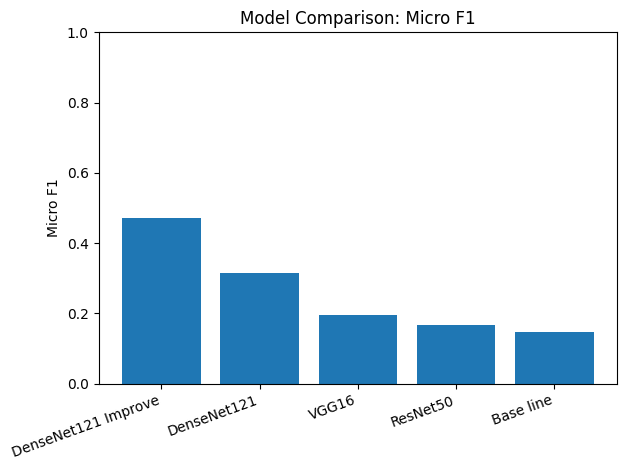

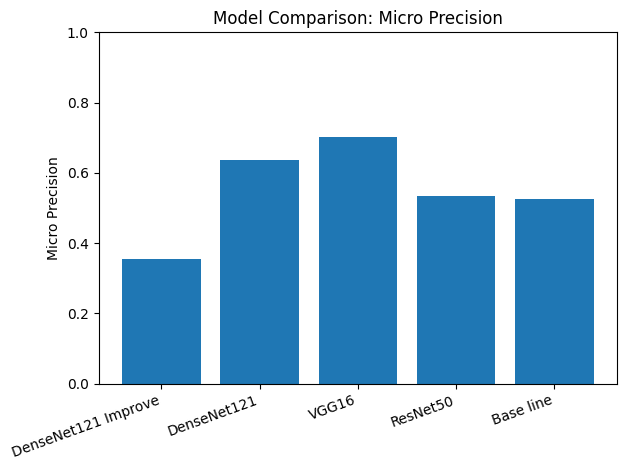

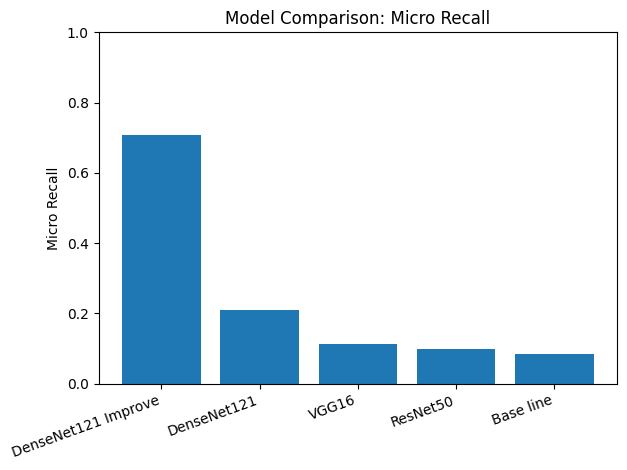

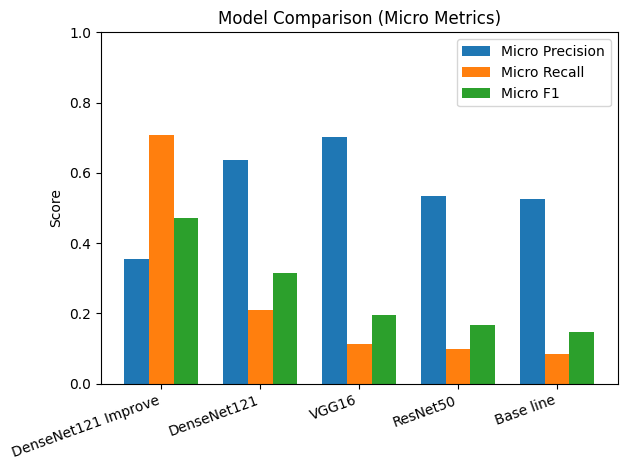

In [ ]:
for m in ["Micro F1", "Micro Precision", "Micro Recall"]:
    plt.figure()
    plt.bar(df_res["Model"], df_res[m])
    plt.ylim(0, 1)
    plt.title(f"Model Comparison: {m}")
    plt.ylabel(m)
    plt.xticks(rotation=20, ha="right")
    plt.tight_layout()
    plt.show()

plt.figure()
x = range(len(df_res))
w = 0.25

plt.bar([i - w for i in x], df_res["Micro Precision"], width=w, label="Micro Precision")
plt.bar(x,                   df_res["Micro Recall"],    width=w, label="Micro Recall")
plt.bar([i + w for i in x], df_res["Micro F1"],         width=w, label="Micro F1")

plt.ylim(0, 1)
plt.xticks(list(x), df_res["Model"], rotation=20, ha="right")
plt.title("Model Comparison (Micro Metrics)")
plt.ylabel("Score")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
df_res.to_csv("model_comparison_micro_metrics.csv",index=False)
print('Saved:model_comparison_micro_metrics.csv')

Saved:model_comparison_micro_metrics.csv


In [ ]:
[k for k in globals().keys() if "model" in k.lower()]

['models',
 'model',
 'Model',
 'ModelCheckpoint',
 'base_model',
 'base_model_resnet',
 'model_resnet',
 'base_model_dense',
 'model_dense']

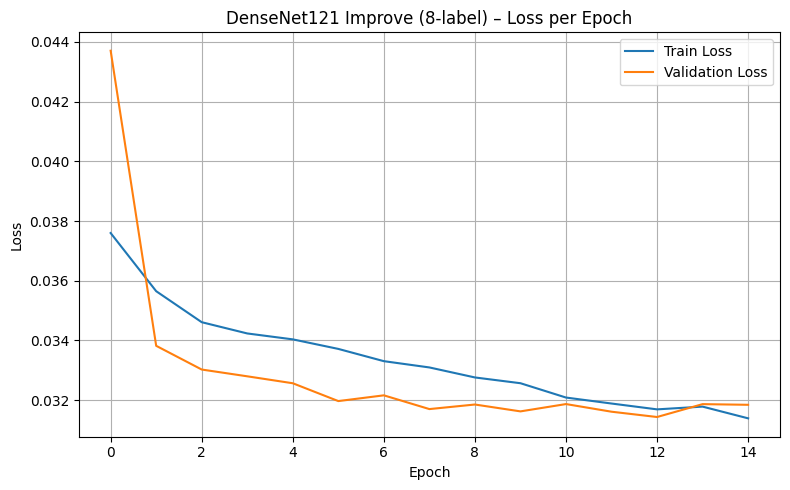

In [ ]:
#loss per Epoch
plt.figure(figsize=(8,5))
plt.plot(history_final.history["loss"], label="Train Loss")
plt.plot(history_final.history["val_loss"], label="Validation Loss")
plt.title("DenseNet121 Improve (8-label) – Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

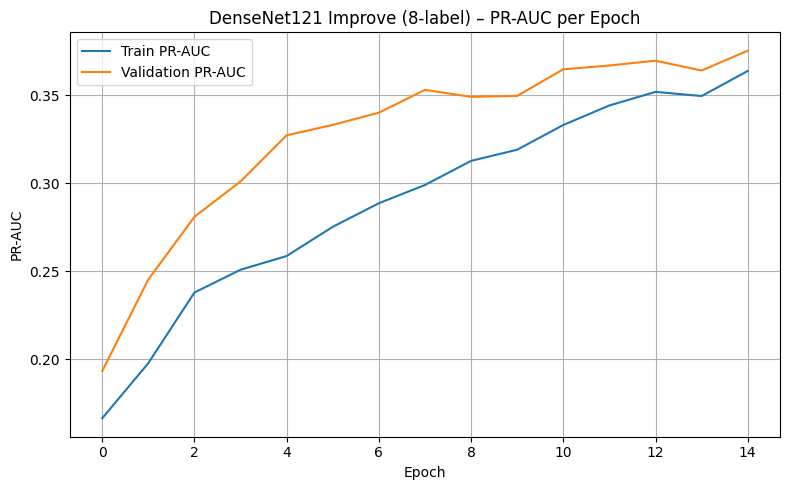

In [ ]:
#PR-AUC per Epoch
plt.figure(figsize=(8,5))
plt.plot(history_final.history["pr_auc"], label="Train PR-AUC")
plt.plot(history_final.history["val_pr_auc"], label="Validation PR-AUC")
plt.title("DenseNet121 Improve (8-label) – PR-AUC per Epoch")
plt.xlabel("Epoch")
plt.ylabel("PR-AUC")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
LABEL_COLS_8 = ["N", "D", "G", "C", "A", "H", "M", "O"]

precision_list = []
recall_list = []
f1_list = []

for i in range(len(LABEL_COLS_8)):
    precision_list.append(
        precision_score(y_true_den_imp[:, i], y_pred_den_imp[:, i], zero_division=0)
    )
    recall_list.append(
        recall_score(y_true_den_imp[:, i], y_pred_den_imp[:, i], zero_division=0)
    )
    f1_list.append(
        f1_score(y_true_den_imp[:, i], y_pred_den_imp[:, i], zero_division=0)
    )

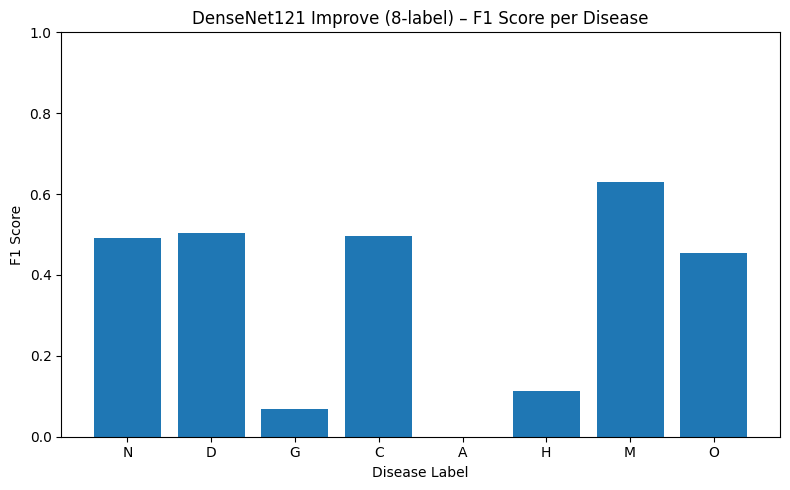

In [ ]:
#Grafik Batang F1 score per label Wajib
plt.figure(figsize=(8,5))
plt.bar(LABEL_COLS_8, f1_list)
plt.ylim(0, 1)
plt.title("DenseNet121 Improve (8-label) – F1 Score per Disease")
plt.xlabel("Disease Label")
plt.ylabel("F1 Score")
plt.tight_layout()
plt.show()

# **Experiment 3 : DenseNet121 Label 6**


In [ ]:
# mapping index dari LABEL_COLS
idx = {name: i for i, name in enumerate(LABEL_COLS)}

def combine_labels(y):
    other_new = (
        (y[:, idx["O"]] == 1) |
        (y[:, idx["A"]] == 1) |
        (y[:, idx["H"]] == 1)
    ).astype(int)

    return np.stack([
        y[:, idx["N"]],
        y[:, idx["D"]],
        y[:, idx["G"]],
        y[:, idx["C"]],
        y[:, idx["M"]],
        other_new
    ], axis=1)

In [ ]:
y_train_6 = combine_labels(y_train)
y_val_6   = combine_labels(y_val)

print("Old:", y_train.shape)
print("New:", y_train_6.shape)

Old: (5600, 8)
New: (5600, 6)


In [ ]:
train_ds_6 = tf.data.Dataset.from_tensor_slices((X_train, y_train_6))
val_ds_6   = tf.data.Dataset.from_tensor_slices((X_val,   y_val_6))

train_ds_6 = train_ds_6.map(load_image_and_label, num_parallel_calls=tf.data.AUTOTUNE)
val_ds_6   = val_ds_6.map(load_image_and_label,   num_parallel_calls=tf.data.AUTOTUNE)

train_ds_6 = train_ds_6.shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_ds_6   = val_ds_6.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [ ]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout

base_model_dn6 = DenseNet121(
    weights="imagenet",
    include_top=False,
    input_shape=IMG_SIZE + (3,)
)

for layer in base_model_dn6.layers:
    layer.trainable = False

x = base_model_dn6.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.5)(x)
outputs = Dense(6, activation="sigmoid")(x)  # <-- 6 label!

model_dn6 = Model(inputs=base_model_dn6.input, outputs=outputs)

model_dn6.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

model_dn6.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_2    │ (None, 230, 230,  │          0 │ input_layer_4[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d_2… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_3    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_3… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 7,301,446 (27.85 MB)

 Trainable params: 263,942 (1.01 MB)

 Non-trainable params: 7,037,504 (26.85 MB)

In [ ]:
history_dn6 = model_dn6.fit(
    train_ds_6,
    validation_data=val_ds_6,
    epochs=20,
    callbacks=[
        EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True, verbose=1)
    ]
)

Epoch 1/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 76s 259ms/step - accuracy: 0.2536 - loss: 0.5722 - val_accuracy: 0.3736 - val_loss: 0.3987
Epoch 2/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 23s 112ms/step - accuracy: 0.3534 - loss: 0.4191 - val_accuracy: 0.4236 - val_loss: 0.3821
Epoch 3/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 23s 113ms/step - accuracy: 0.3790 - loss: 0.4025 - val_accuracy: 0.4279 - val_loss: 0.3737
Epoch 4/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 23s 113ms/step - accuracy: 0.3882 - loss: 0.3950 - val_accuracy: 0.4536 - val_loss: 0.3702
Epoch 5/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 23s 113ms/step - accuracy: 0.4112 - loss: 0.3854 - val_accuracy: 0.4514 - val_loss: 0.3653
Epoch 6/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 23s 112ms/step - accuracy: 0.4115 - loss: 0.3815 - val_accuracy: 0.4564 - val_loss: 0.3635
Epoch 7/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 23s 113ms/step - accuracy: 0.4150 - loss: 0.3791 - val_accuracy: 0.4500 - val_loss: 0.3602
Epoch 8/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 23s 113ms/step - accuracy: 0.4337 - loss: 0

In [ ]:
import numpy as np
from sklearn.metrics import f1_score, classification_report

LABEL_COLS_6 = ["N","D","G","C","M","Other_new"]

y_true_list, y_prob_list = [], []

for xb, yb in val_ds_6:
    p = model_dn6.predict(xb, verbose=0)
    y_true_list.append(yb.numpy())
    y_prob_list.append(p)

y_true_6 = np.vstack(y_true_list)
y_prob_6 = np.vstack(y_prob_list)

# threshold default dulu
y_pred_6 = (y_prob_6 >= 0.5).astype(int)

print("Micro F1:", f1_score(y_true_6, y_pred_6, average="micro", zero_division=0))
print("\nReport:\n")
print(classification_report(y_true_6, y_pred_6, target_names=LABEL_COLS_6, zero_division=0))

Micro F1: 0.3035128805620609

Report:

              precision    recall  f1-score   support

           N       0.59      0.13      0.21       438
           D       0.57      0.22      0.32       442
           G       1.00      0.02      0.05        85
           C       0.91      0.69      0.79        91
           M       0.85      0.67      0.75        69
   Other_new       0.56      0.11      0.19       514

   micro avg       0.65      0.20      0.30      1639
   macro avg       0.75      0.31      0.38      1639
weighted avg       0.63      0.20      0.28      1639
 samples avg       0.21      0.20      0.20      1639



In [ ]:
best_th, best_f1 = None, -1
for th in np.arange(0.05, 0.55, 0.05):
    y_pred = (y_prob_6 >= th).astype(int)
    f1 = f1_score(y_true_6, y_pred, average="micro", zero_division=0)
    if f1 > best_f1:
        best_f1, best_th = f1, th

print("Best threshold:", best_th)
print("Best Micro F1:", best_f1)

Best threshold: 0.3
Best Micro F1: 0.5602409638554217


In [ ]:
TH6 = 0.2777
y_pred_6_final = (y_prob_6 >= TH6).astype(int)

print("Micro Precision:", precision_score(y_true_6, y_pred_6_final, average="micro", zero_division=0))
print("Micro Recall   :", recall_score(y_true_6, y_pred_6_final, average="micro", zero_division=0))
print("Micro F1       :", f1_score(y_true_6, y_pred_6_final, average="micro", zero_division=0))
print("\nPer-label report:\n")
print(classification_report(y_true_6, y_pred_6_final, target_names=LABEL_COLS_6, zero_division=0))

Micro Precision: 0.4298627385336458
Micro Recall   : 0.7834045149481391
Micro F1       : 0.5551232166018158

Per-label report:

              precision    recall  f1-score   support

           N       0.43      0.76      0.55       438
           D       0.38      0.85      0.53       442
           G       0.51      0.22      0.31        85
           C       0.74      0.80      0.77        91
           M       0.76      0.77      0.76        69
   Other_new       0.42      0.83      0.56       514

   micro avg       0.43      0.78      0.56      1639
   macro avg       0.54      0.71      0.58      1639
weighted avg       0.45      0.78      0.56      1639
 samples avg       0.46      0.79      0.55      1639



## ***Coba threshold per label***

In [ ]:
LABEL_COLS_6 = ["N","D","G","C","M","Other_new"]
label_idx = {label: i for i, label in enumerate(LABEL_COLS_6)}

best_thresholds = {}

for label in LABEL_COLS_6:
    i = label_idx[label]
    best_f1, best_th = -1, 0.5

    for th in np.arange(0.05, 0.55, 0.05):
        y_pred_label = (y_prob_6[:, i] >= th).astype(int)
        f1 = f1_score(y_true_6[:, i], y_pred_label, zero_division=0)

        if f1 > best_f1:
            best_f1, best_th = f1, th

    best_thresholds[label] = best_th
    print(f"{label}: best_th={best_th:.2f}, best_f1={best_f1:.3f}")

y_pred_pl = np.zeros_like(y_prob_6, dtype=int)

for label, th in best_thresholds.items():
    i = label_idx[label]
    y_pred_pl[:, i] = (y_prob_6[:, i] >= th).astype(int)


print("Micro Precision:", precision_score(y_true_6, y_pred_pl, average="micro", zero_division=0))
print("Micro Recall   :", recall_score(y_true_6, y_pred_pl, average="micro", zero_division=0))
print("Micro F1       :", f1_score(y_true_6, y_pred_pl, average="micro", zero_division=0))
print("\nPer-label report:\n")
print(classification_report(y_true_6, y_pred_pl, target_names=LABEL_COLS_6, zero_division=0))

N: best_th=0.30, best_f1=0.550
D: best_th=0.30, best_f1=0.537
G: best_th=0.15, best_f1=0.393
C: best_th=0.35, best_f1=0.800
M: best_th=0.35, best_f1=0.769
Other_new: best_th=0.30, best_f1=0.568
Micro Precision: 0.44629294755877036
Micro Recall   : 0.7528981086028066
Micro F1       : 0.5603996366939146

Per-label report:

              precision    recall  f1-score   support

           N       0.45      0.70      0.55       438
           D       0.40      0.81      0.54       442
           G       0.33      0.49      0.39        85
           C       0.83      0.77      0.80        91
           M       0.82      0.72      0.77        69
   Other_new       0.44      0.79      0.57       514

   micro avg       0.45      0.75      0.56      1639
   macro avg       0.55      0.72      0.60      1639
weighted avg       0.47      0.75      0.57      1639
 samples avg       0.47      0.76      0.55      1639



In [ ]:
!ls
from google.colab import files

files.download("densenet121_best_final.h5")
files.download("densenet121_final_odir5k.h5")
files.download("densenet121_stage1_best.h5")
files.download("densenet121_stage2_best.h5")
files.download("resnet50_final_odir5k.h5")
files.download("resnet50_stage1_best.h5")
files.download("resnet50_stage2_best.h5")
files.download("vgg16_final_odir5k.h5")
files.download("vgg16_stage1_best.h5")
files.download("vgg16_stage2_best.h5")